In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys, pathlib

# Project-1 folder (parent of this Notebooks/ folder)
proj_dir = pathlib.Path.cwd().parent
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))

# Figures folder
fig_dir = proj_dir / "Figures"
fig_dir.mkdir(parents=True, exist_ok=True)

from Code.data import make_data, build_features, split_and_scale

# --- Project-wide experiment config (used in ALL notebooks) ---

# Data settings
N_SAMPLES   = 300     # number of samples
NOISE_SD    = 0.3     # noise standard deviation
SEED_DATA   = 42      # data generation
SEED_SPLIT  = 42      # train/test split (split_and_scale uses this)
DEG_MAX     = 15      # max polynomial degree for features
P_FIXED     = 15      # fixed polynomial degree for regularization experiments
TEST_SIZE   = 0.20    # train/test split size


# Regularization grids
LAM_GRID_RIDGE = np.logspace(-6, 1, 40)  # wider range for ridge
LAM_GRID_LASSO = np.logspace(-6, 0, 60)  # less range for LASSO

# Optimizer settings
ETA_FULL   = 5e-3     # full-batch GD steps
ITERS_FULL = 5000     # full-batch GD iterations
LAM_RIDGE  = 0.0203   # Taken from ridge experiments (02_Ridge_lambda.ipynb) best lambda for degree 15
BETA = 0.3    # momentum parameter
B1 = 0.9    # Adam parameter
B2 = 0.999  # Adam parameter
EPS = 1e-8  # Adam parameter
RHO = 0.99  # Adadelta parameter

# Mini-batch SGD
EPOCHS_MB    = 25     # passes over data
BATCH_SIZE   = 64     # minibatch size
ETA_MB_OLS   = 1e-2   # for OLS, can be larger
ETA_MB_RIDGE = 1e-2   # for ridge, need to tune
SEED_MB      = 42     # minibatch shuffle

# Resampling and CV
B = 200 # bootstrap samples
K = 10 # folds

# --- Generate data explicitly---
x, y = make_data(n=N_SAMPLES, noise_sd=NOISE_SD, seed=SEED_DATA)
X_full = build_features(x, degree=DEG_MAX, include_bias=False)


#X_tr_s, X_te_s, y_tr_c, y_te, scaler, y_mean = split_and_scale(X_full, y, test_size=TEST_SIZE, random_state=SEED_SPLIT)



In [3]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from Code.resampling import bootstrap_predictions, bias_variance_from_preds
from Code.models import fit_ols, predict_centered

/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e-01, tolerance: 4.903e-03
  model = cd_fast.enet_coordinate_descent(
/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.256e-02, tolerance: 4.876e-03
  model = cd_fast.enet_coordinate_descent(
/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/.venv/lib/python3.12/site-packages/sklearn/linea

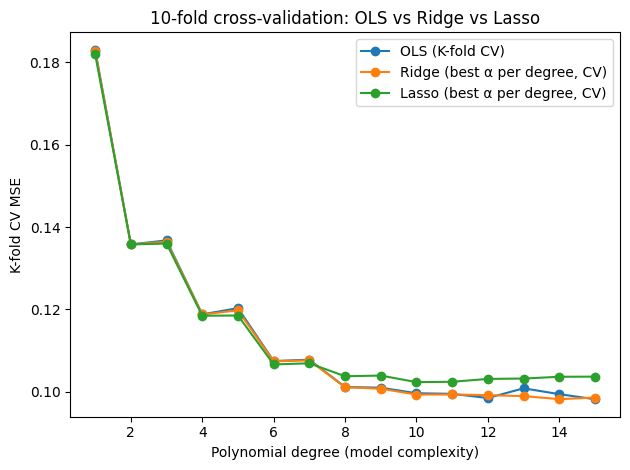

In [ ]:
# ----- data -----
rng = np.random.default_rng(SEED_DATA)        
X = x.reshape(-1, 1)                                    

degrees = list(range(1, DEG_MAX + 1))

cv = KFold(n_splits=K, shuffle=True, random_state=SEED_DATA)


def cv_curve(model, degrees, X, y, cv):
    """Return mean and std of K-fold MSE across degrees for a given base model."""
    means, stds = [], []
    for d in degrees:
        pipe = Pipeline([
            ("poly", PolynomialFeatures(d, include_bias=False)),
            ("scaler", StandardScaler()),
            ("model", model)
        ])
        # sklearn returns NEGATIVE MSE; flip the sign
        scores = -cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_squared_error")
        means.append(scores.mean())
        stds.append(scores.std(ddof=1))
    return np.array(means), np.array(stds)

# OLS 
mse_ols, sd_ols = cv_curve(LinearRegression(fit_intercept=True), degrees, X, y, cv)

# Ridge: pick best alpha per degree from a small grid 
alphas_ridge = np.logspace(-4, 2, 9)   # 1e-4 ... 1e2
mse_ridge = []
for d in degrees:
    best = np.inf
    for a in alphas_ridge:
        pipe = Pipeline([
            ("poly", PolynomialFeatures(d, include_bias=False)),
            ("scaler", StandardScaler()),
            ("model", Ridge(alpha=a, fit_intercept=True, random_state=SEED_DATA))
        ])
        scores = -cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_squared_error")
        best = min(best, scores.mean())
    mse_ridge.append(best)
mse_ridge = np.array(mse_ridge)

# Lasso: 
alphas_lasso = np.logspace(-4, 1, 10)  # 1e-4 ... 10
mse_lasso = []
for d in degrees:
    best = np.inf
    for a in alphas_lasso:
        pipe = Pipeline([
            ("poly", PolynomialFeatures(d, include_bias=False)),
            ("scaler", StandardScaler()),
            ("model", Lasso(alpha=a, fit_intercept=True, max_iter=ITERS_FULL, random_state=SEED_DATA))
        ])
        scores = -cross_val_score(pipe, X, y, cv=cv, scoring="neg_mean_squared_error")
        best = min(best, scores.mean())
    mse_lasso.append(best)
mse_lasso = np.array(mse_lasso)


plt.figure()
plt.plot(degrees, mse_ols,   marker="o", label="OLS (K-fold CV)")
plt.plot(degrees, mse_ridge, marker="o", label="Ridge (best α per degree, CV)")
plt.plot(degrees, mse_lasso, marker="o", label="Lasso (best α per degree, CV)")
plt.xlabel("Polynomial degree (model complexity)")
plt.ylabel("K-fold CV MSE")
plt.title(f"{K}-fold cross-validation: OLS vs Ridge vs Lasso")
plt.legend(); plt.tight_layout()

#plt.savefig(f"figures/cv_mse_k{K}.png", dpi=300, bbox_inches="tight") 

plt.savefig(fig_dir / "cv_mse.png", dpi=300, bbox_inches="tight")




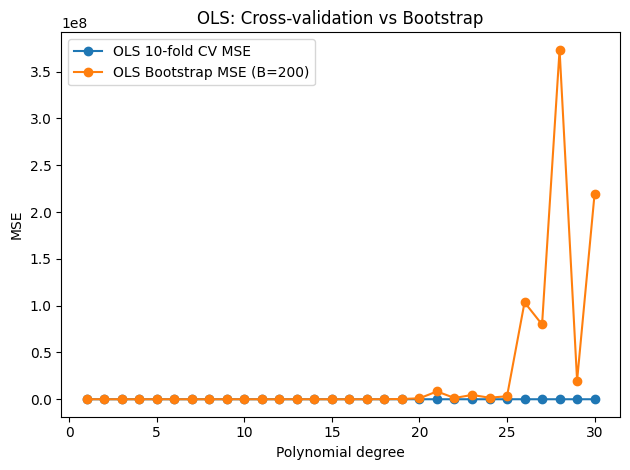

In [ ]:
# ----- bootstrap "test MSE" on a fixed split  -----
split = lambda X,Y: split_and_scale(X, Y, test_size=0.3, random_state=1, center_y=True) 

X_full = build_features(x, degree=deg_max, include_bias=False)
X_tr_s, X_te_s, y_tr_c, y_te, _, y_mean = split(X_full, y)

B = 200
mse_boot = []
for p in degrees:
    P = bootstrap_predictions(
        fit_fn=fit_ols,
        pred_fn=predict_from_theta,
        Xtr_s=X_tr_s[:, :p],
        ytr_c=y_tr_c,
        Xte_s=X_te_s[:, :p],
        y_mean=y_mean,
        B=B, seed=1
    )
    _, _, mse_p = bias_variance_from_preds(P, y_true=y_te.ravel())
    mse_boot.append(mse_p)
mse_boot = np.array(mse_boot)

# ----- overlay plot: CV vs Bootstrap (OLS) -----
plt.figure()
plt.plot(degrees, mse_ols,  marker="o", label=f"OLS {K}-fold CV MSE")
plt.plot(degrees, mse_boot, marker="o", label=f"OLS Bootstrap MSE (B={B})")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.title("OLS: Cross-validation vs Bootstrap")
plt.legend(); plt.tight_layout()

plt.savefig(fig_dir / "OLS_cv_vs_bootstrap.png", dpi=300, bbox_inches="tight")

